In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np


In [2]:
training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

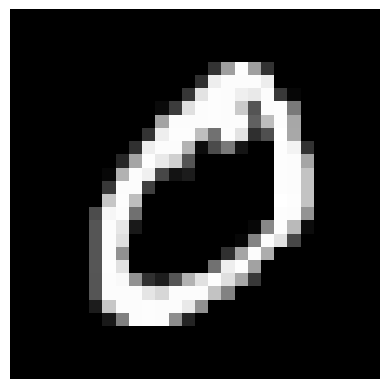

In [3]:
img, label = training_data[1]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

In [4]:
img.shape

torch.Size([1, 28, 28])

In [5]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
train_labels = training_data.train_labels

/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Text(0.5, 1.0, 'MINST Dataset Analysis')

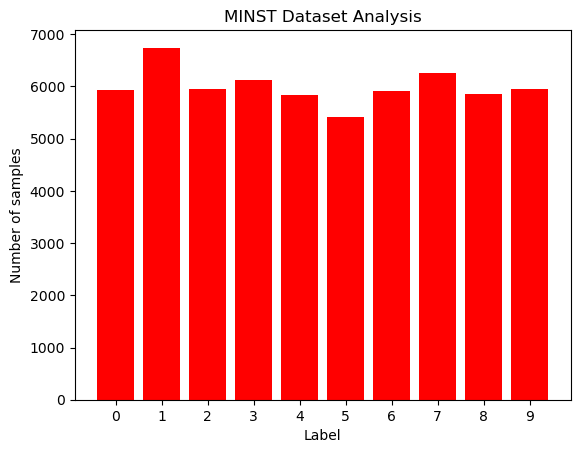

In [7]:
labels_counts = np.unique(train_labels.numpy(), return_counts=True)
x_values = []
for idx, v in enumerate(labels_counts[0]):
    x_values.append(str(v))
    
print(x_values)
plt.bar(x_values, labels_counts[1], color = "red")
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.title("MINST Dataset Analysis")

## Building a neural network

In [8]:
print("GPU: {}", torch.cuda.is_available())
print("MPS: {}", torch.backends.mps.is_available())

GPU: {} False
MPS: {} True


Choose right device to make computations

In [9]:
device = torch.device("mps:0")
device

device(type='mps', index=0)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = NeuralNetwork().to(device)

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [12]:
train_loss = []
test_losses = []

In [13]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss= 0.
    last_loss = 0.
    for i,  data in enumerate(train_dataloader):
        inputs, labels = data
        inputs.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Adjust learning weights 
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print("Batch {}, loss: {}".format(i+1, last_loss))
            tb_x = epoch_index*len(train_dataloader)+i+1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [14]:
from torch.utils.tensorboard import SummaryWriter
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter()
epoch_number = 0

EPOCHS = 11

best_vloss = 1_000_000

train_losses_history = []
validation_losses_history = []

for epoch in range(EPOCHS):
    print("EPOCH: {}".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    train_losses_history.append(avg_loss)
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(train_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    validation_losses_history.append(avg_vloss)
    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH: 1


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
print(train_losses_history)

NameError: name 'train_losses_history' is not defined

In [ ]:
saved_model = NeuralNetwork()
saved_model.load_state_dict(torch.load("./model_20231107_155150_4"))

<All keys matched successfully>

In [ ]:
saved_model.eval()

tensor([[ 11.9522, -10.5729,   2.8910,  -0.3570,  -7.9878,   1.8000,  -2.8691,
           0.9283,  -1.8278,   1.0534]], grad_fn=<AddmmBackward0>)

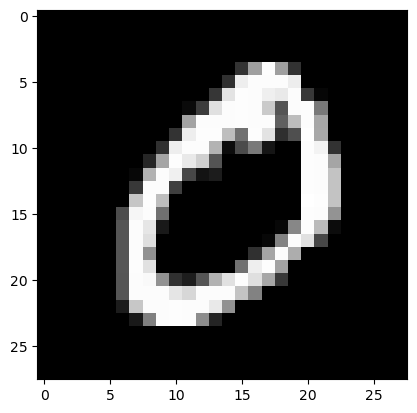

In [ ]:
plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
training_data.classes[np.argmax(saved_model(img).detach().numpy())]

'0 - zero'

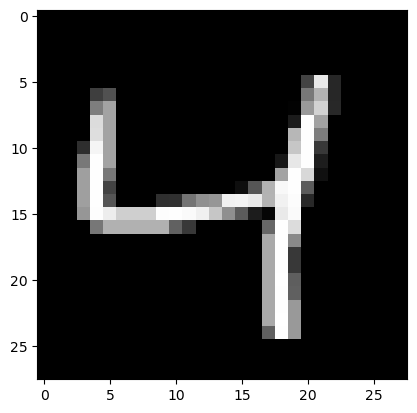

In [ ]:
img2, label = training_data[2]
plt.imshow(img2.squeeze(), cmap="gray")

In [ ]:
training_data.classes[np.argmax(saved_model(img2).detach().numpy())]

'4 - four'